In [1]:
from PreFRBLE.likelihood import *
from PreFRBLE.plot import *


to identify LoS with intervening galaxies, compare the likelihood of temporal broadening $\tau$ for scenarios with and without intervening galaxies

In [2]:
## LoS without intervening galaxy

scenario_nointer = {
    'IGM' : ['primordial'],
    'Host' : ['Rodrigues18'],
    'Local' : ['Piro18/wind'],
}

## LoS with intervening galaxy
scenario_inter = scenario_nointer.copy()
scenario_inter['Inter'] = ['Rodrigues18']

## same as
scenario_inter = {
    'IGM' : ['primordial'],
    'Host' : ['Rodrigues18'],
    'Local' : ['Piro18/wind'],
    'Inter' : ['Rodrigues18'],
}

## Both scenarios mixed according to expected number of intervening galaxies N_inter as function of redshift ( NInter )
## not actually used here
scenario_inter_realistic = scenario_inter.copy()
scenario_inter_realistic['N_inter'] = True

## same as
scenario_inter_realistic = {
    'IGM' : ['primordial'],
    'Host' : ['Rodrigues18'],
    'Local' : ['Piro18/wind'],
    'Inter' : ['Rodrigues18'],
    'N_inter' : True
}


### compare likelihoods
first, compare the distribution of $\tau$ expected to be observed by ASKAP, CHIME and Parkes

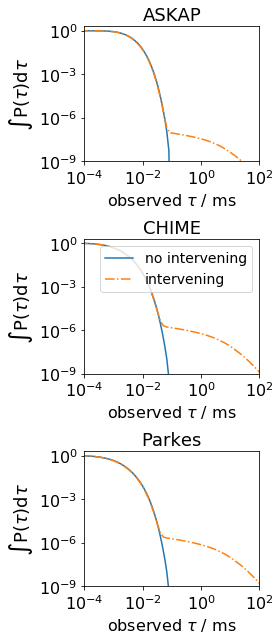

In [22]:
#fig, axs = plt.subplots( 1, len(telescopes), figsize=(4*len(telescopes), 3) )
fig, axs = plt.subplots( len(telescopes), 1, figsize=(4, len(telescopes)* 3) )

population = 'SMD'

for telescope, ax in zip( telescopes, axs):
    for i_s, scenario in enumerate([scenario_inter, scenario_nointer][::-1]):
        P = GetLikelihood_Telescope( measure='tau', telescope=telescope, population='SMD', dev=False, **scenario )
        PlotLikelihood( *P, ax=ax, label=('no ' if not i_s else '')+'intervening', linestyle='-.' if i_s else "-", measure='tau' , cumulative=-1 )#density=True )
    ax.set_title(labels[telescope], fontsize=18)
    ax.set_ylim(1e-9,2)
    ax.set_xlim(1e-4, 1e2)
#    ax.set_yscale('linear')
    AllSidesTicks(ax)
#for i in range(3):
#    axs[i].legend(fontsize=16, loc=4+i)
axs[1].legend(fontsize=14, loc=1)
fig.tight_layout()

### Bayes factor
calculate bayes factor as ratio of the two likelihood functions shown above and plot as function of $\tau$.
For $\mathcal{B(\tau)}>10^2$, the LoS is intersected by an intervening galaxy with >99% certainty.

/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:195: RuntimeWarning: invalid value encountered in double_scalars
  dev[ib] += add**2 * ( np.sum( ( devs[i_f][ix]*f[ix]*np.diff(x_) )**2 ) /np.sum( ( f[ix]*np.diff(x_) )**2 )  + dev_weights[i_f]**2 )
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:198: RuntimeWarning: invalid value encountered in true_divide
  dev = np.sqrt(dev)/P
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:419: RuntimeWarning: divide by zero encountered in true_divide
  bayes =  P1/P2
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:419: RuntimeWarning: invalid value encountered in true_divide
  bayes =  P1/P2


70
19 of 70 returned NaN. Ignore in final result
could not find B>100
B_last 1.0 at -1
ASKAP_incoh: decisive for intervening galaxies: tau>0.162 ms
ASKAP_incoh, 0.000007 % of interveners identified
ASKAP_incoh, 0.000000 % of others give false positives
70
18 of 70 returned NaN. Ignore in final result
could not find B>100
B_last 1.0 at -1
CHIME: decisive for intervening galaxies: tau>0.162 ms
CHIME, 0.000124 % of interveners identified
CHIME, 0.000000 % of others give false positives
70
18 of 70 returned NaN. Ignore in final result
could not find B>100
B_last 1.0 at -1
Parkes: decisive for intervening galaxies: tau>0.162 ms
Parkes, 0.000154 % of interveners identified
Parkes, 0.000000 % of others give false positives


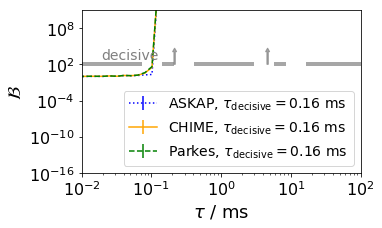

In [30]:
#fig, axs = plt.subplots( 1, len(telescopes), figsize=(4*len(telescopes), 3) )
fig, ax = plt.subplots( figsize=(5,3))

population = 'SMD'

#for telescope, ax in zip( telescopes, axs):
for telescope, color, linestyle in zip(telescopes, colors_telescope, linestyles_population):
    P_i = GetLikelihood_Telescope( measure='tau', telescope=telescope, population='SMD', dev=True, **scenario_inter )
    P = GetLikelihood_Telescope( measure='tau', telescope=telescope, population='SMD', dev=True, **scenario_nointer )
    
    ## force both P to same range
    
    ## give both P ranges the same min and max
    x_max = np.min( [P[1][-1],P_i[1][-1]] )
    x_min = np.max( [P[1][0],P_i[1][0]] )
    P = LikelihoodMeasureable( *P, min=x_min, max=x_max)
    P_i = LikelihoodMeasureable( *P_i, min=x_min, max=x_max)
    
    ## give both P the same number of  bins
    bins = np.min([len(P[0]), len(P_i[0])])   
    print(bins)
    P = LikelihoodShrink(*P, bins=bins)
    P_i = LikelihoodShrink(*P_i, bins=bins)

    ## check if successfull
    if not np.all(P[1] == P_i[1]):
        print("try harder!")
        print(P[1], P_i[1])
        break
#    """
    
    B = BayesFactors( P1=P_i[0], P2=P[0] )
    dev_B =  np.sqrt( P_i[2]**2 + P[2]**2 )
    
    try:
        i_tau = first( range(len(B)), lambda i: B[i] > 1e2 )
    except:
        print( "could not find B>100")
        #try:## NaNs, beaucse P_nointer=0?
        #    i_tau = first( range(len(B)), lambda i: B[i] == 1 )
        #except: 
        #    print( "could also not find NaNs")
    ## highest value of P_nointer>0
        i_tau = -1  ### by construction, last value
    print( "B_last {} at {}".format( B[i_tau],i_tau) )
        
    tau_decisive = P[1][1:][i_tau]
    print( "{}: decisive for intervening galaxies: tau>{:.3f} ms".format(telescope,tau_decisive))

    ## better aestethics for results with P = 0
    B[B==1] = B[B!=1][-1] * 10.**np.arange(sum(B==1))
    
    ax.errorbar( P[1][1:], B, yerr=B*dev_B, label=r"%s, $\tau_{\rm decisive} = %.2f$ ms" % (labels[telescope], tau_decisive), color=color, linestyle=linestyle )
    ax.set_xlabel( r"$\tau$ / ms", fontdict={'size':18 } )
    ax.set_ylabel( r"$\mathcal{B}$", fontdict={'size':18 }  )

    
    ## compute how many LoS with intervening galaxies are identified / false positives
    P_i, x_i = GetLikelihood_Telescope( measure='tau', telescope=telescope, population='SMD', **scenario_inter )
    P, x = GetLikelihood_Telescope( measure='tau', telescope=telescope, population='SMD', **scenario_nointer )

    i_tau = first( range(len(P_i)), lambda i: x_i[i] > tau_decisive )
    print( "%s, %.6f %% of interveners identified" % ( telescope, 100*np.sum( P_i[i_tau:]*np.diff(x_i)[i_tau:] ) ) )

    try:
        i_tau = first( range(len(P)), lambda i: x[i] > tau_decisive )
    except: ## fails, if chosen  highest value of noInter
        i_tau = -1
    print( "%s, %.6f %% of others give false positives" % ( telescope, 100*np.sum( P[i_tau:]*np.diff(x)[i_tau:] ) ) )

ax.legend(loc='lower right', fontsize=14)
ax.loglog()
ax.set_xlim(1e-2,1e2)
ax.set_ylim(1e-16,1e11)
PlotLimit(ax=ax, x=ax.get_xlim(), y=[1e2,1e2], lower_limit=True, label='decisive', shift_text_vertical=3e3, shift_text_horizontal=-0.95)
ax.tick_params(axis='both', which='major', labelsize=16)
#AllSidesTicks(ax)
#    """
    

In [ ]:
plot()